In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
adityamahimkar_iqothnccd_lung_cancer_dataset_path = kagglehub.dataset_download('adityamahimkar/iqothnccd-lung-cancer-dataset')
print('Data source import complete.')

Using Colab cache for faster access to the 'iqothnccd-lung-cancer-dataset' dataset.
Data source import complete.


# Import Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import random
import os
import imageio.v2 as imageio
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import tensorflow as tf
import keras

from PIL import Image
from plotly.subplots import make_subplots
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [ ]:
# Menentukan Lokasi Dataset dan Kategori
directory = os.path.join(adityamahimkar_iqothnccd_lung_cancer_dataset_path, 'The IQ-OTHNCCD lung cancer dataset', 'The IQ-OTHNCCD lung cancer dataset')
# Menentukan kategori kelas citra
categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

# Menampilkan Informasi Dataset
print(f"Dataset directory: {directory}")
print(f"Image categories: {categories}", "\n")

# Melihat isi folder utama dataset
print(os.listdir(adityamahimkar_iqothnccd_lung_cancer_dataset_path))
# Melihat isi folder dataset sebenarnya
print(os.listdir(directory))

Dataset directory: /kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset
Image categories: ['Bengin cases', 'Malignant cases', 'Normal cases'] 

['Test cases', 'The IQ-OTHNCCD lung cancer dataset']
['IQ-OTH_NCCD lung cancer dataset.txt', 'Normal cases', 'Bengin cases', 'Malignant cases']


* Test cases
* The IQ-OTHNCCD lung cancer dataset
  * The IQ-OTHNCCD lung cancer dataset
    * Bengin cases
    * Malignant cases
    * Normal cases
  

# Image Size Variations

In [ ]:
size_data = {}
# Mengambil nama kelas saat ini dan menetapkannya ke variabel
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    # Melakukan iterasi melalui
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        # Menambah hitungan jika ukuran sudah ada
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1
        # Menginisialisasi hitungan baru jika ukuran belum pernah ditemukan
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1

    size_data[i] = temp_dict

size_data

{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '512 x 623': 31,
  '512 x 801': 28,
  '404 x 511': 1},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

Bengin cases


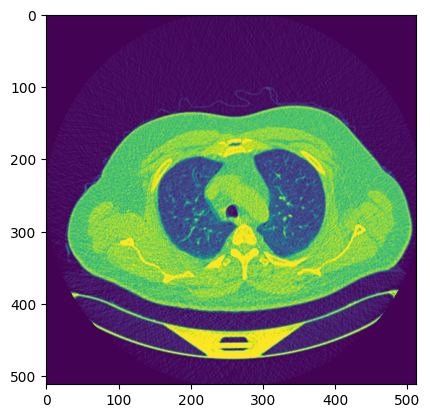

Malignant cases


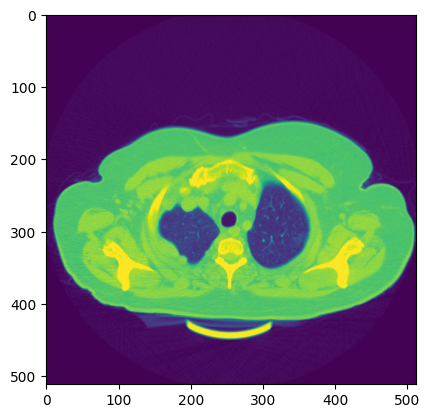

Normal cases


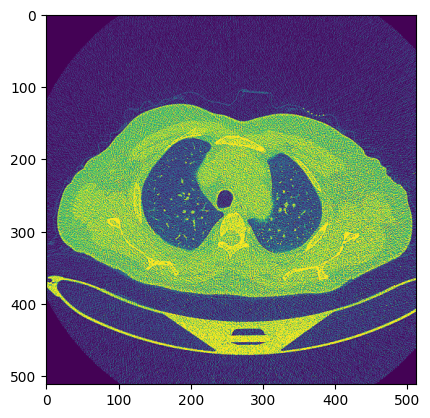

In [ ]:
# Iterasi kategori
for i in categories:
  path = os.path.join(directory, i)
  class_num = categories.index(i)

  # Membangun path
  for file in os.listdir(path):
    filepath = os.path.join(path, file)
    print(i)
    img = cv2.imread(filepath, 0)

    # Membaca dan menampilkan gambar
    plt.imshow(img)
    plt.show()
    break

# Image Preprocessing and Testing

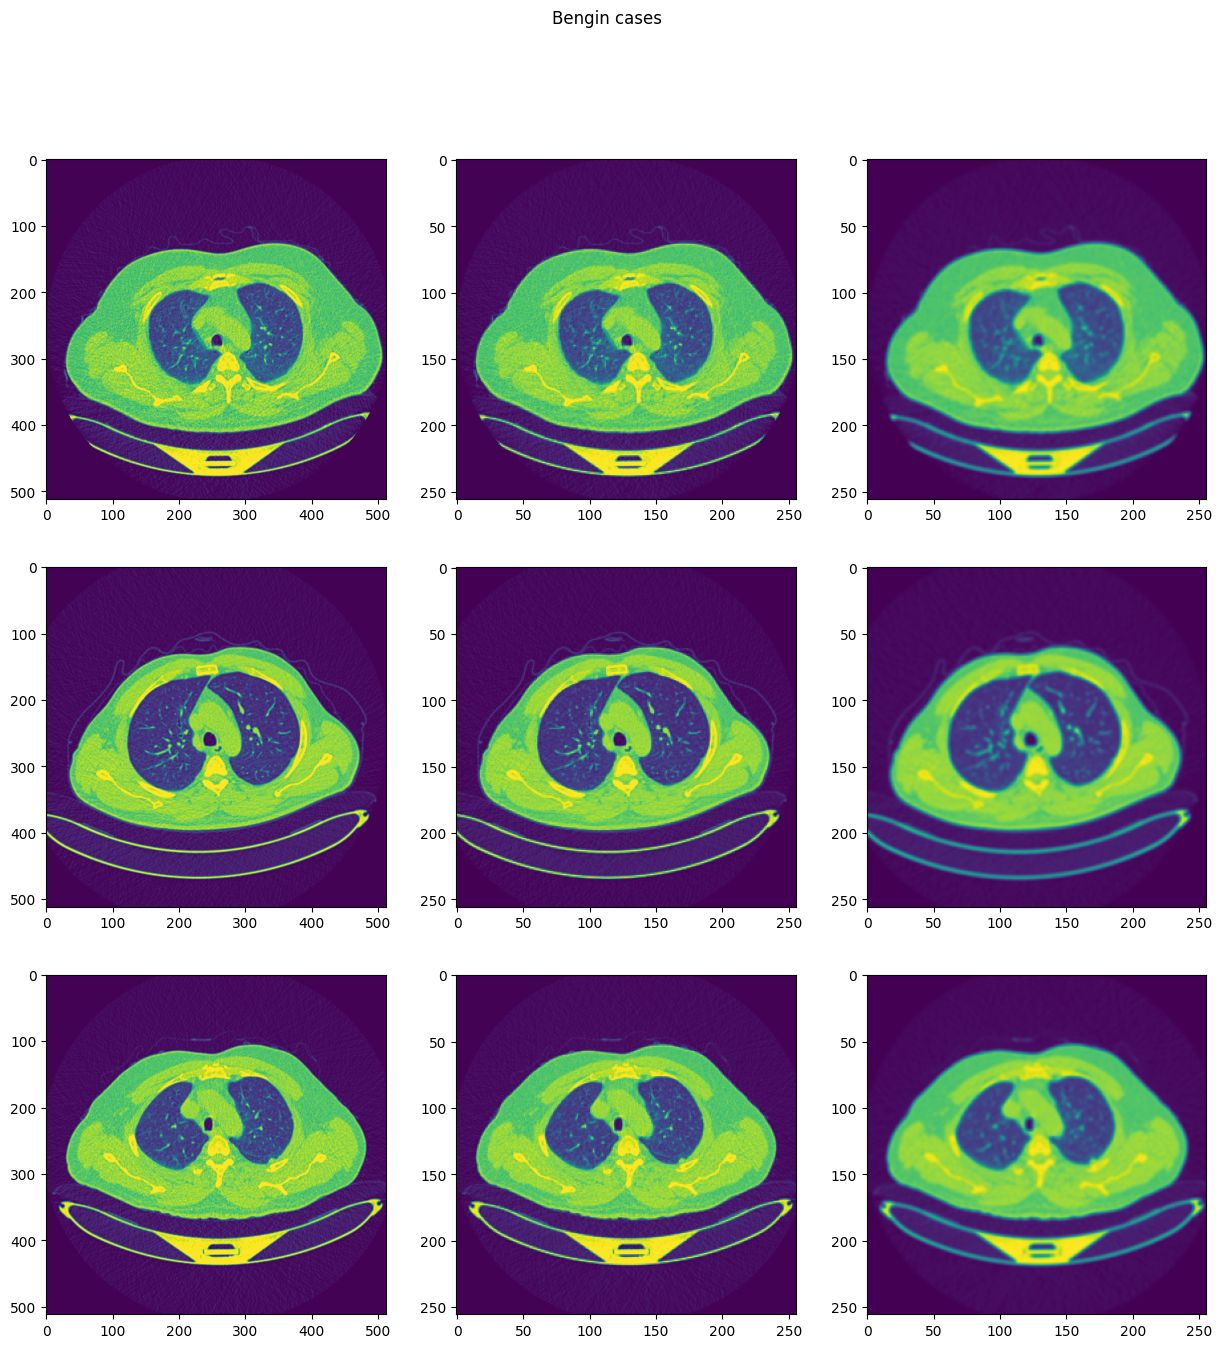

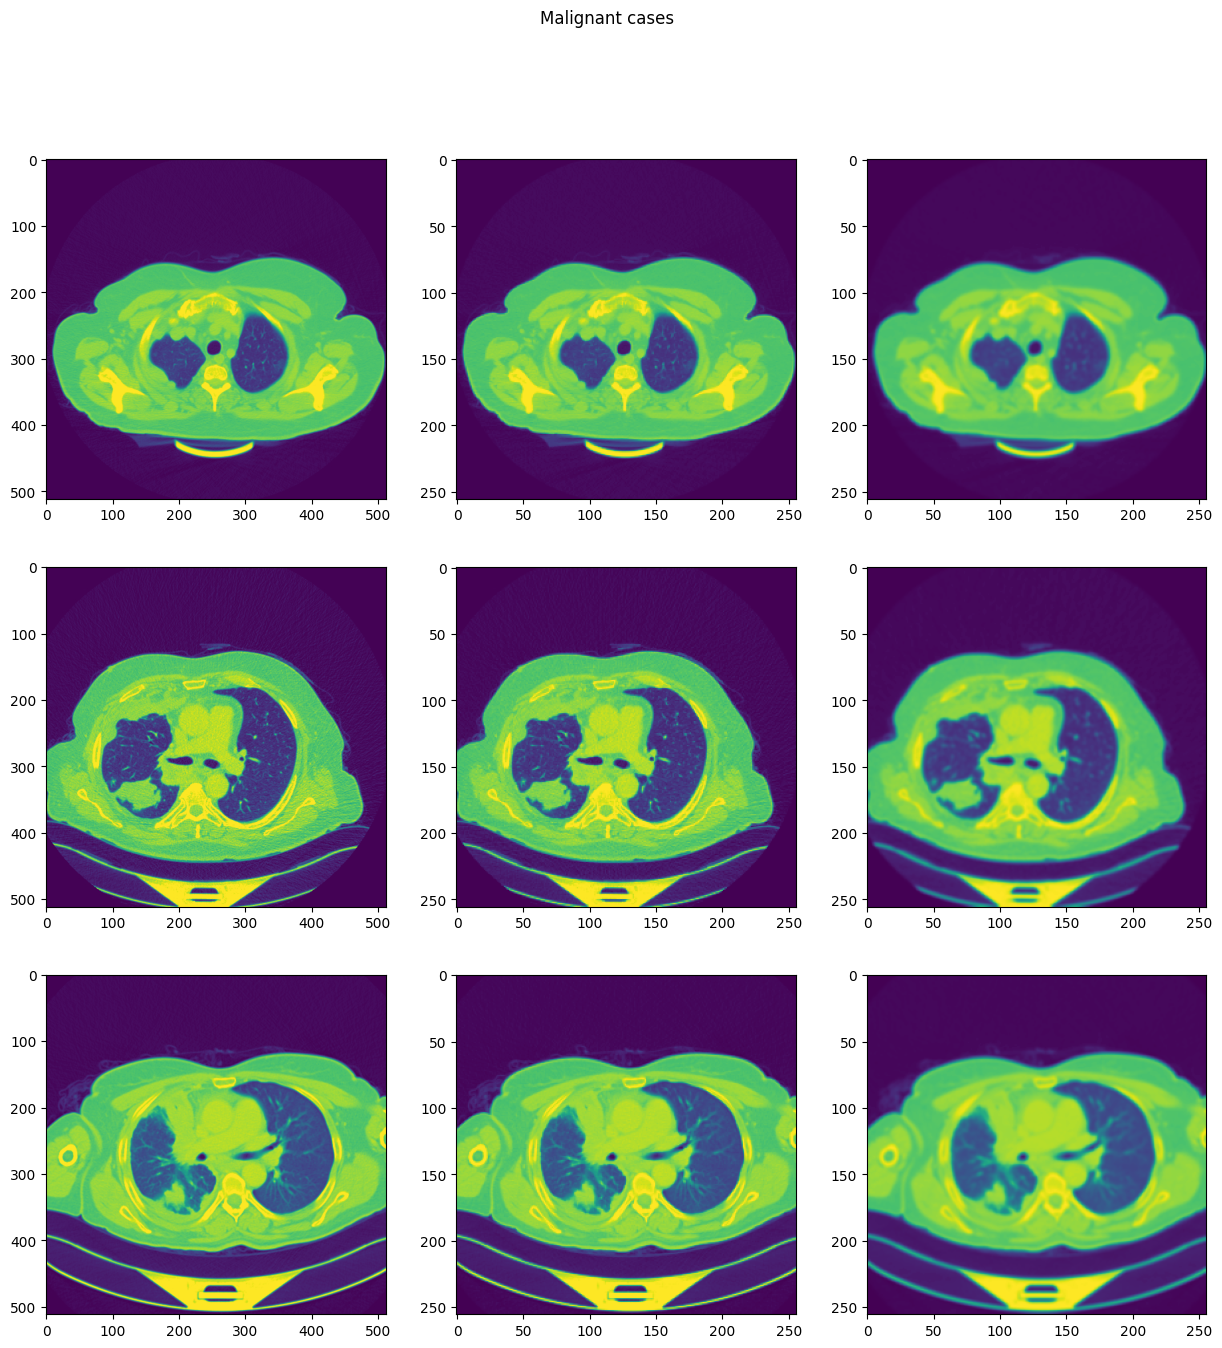

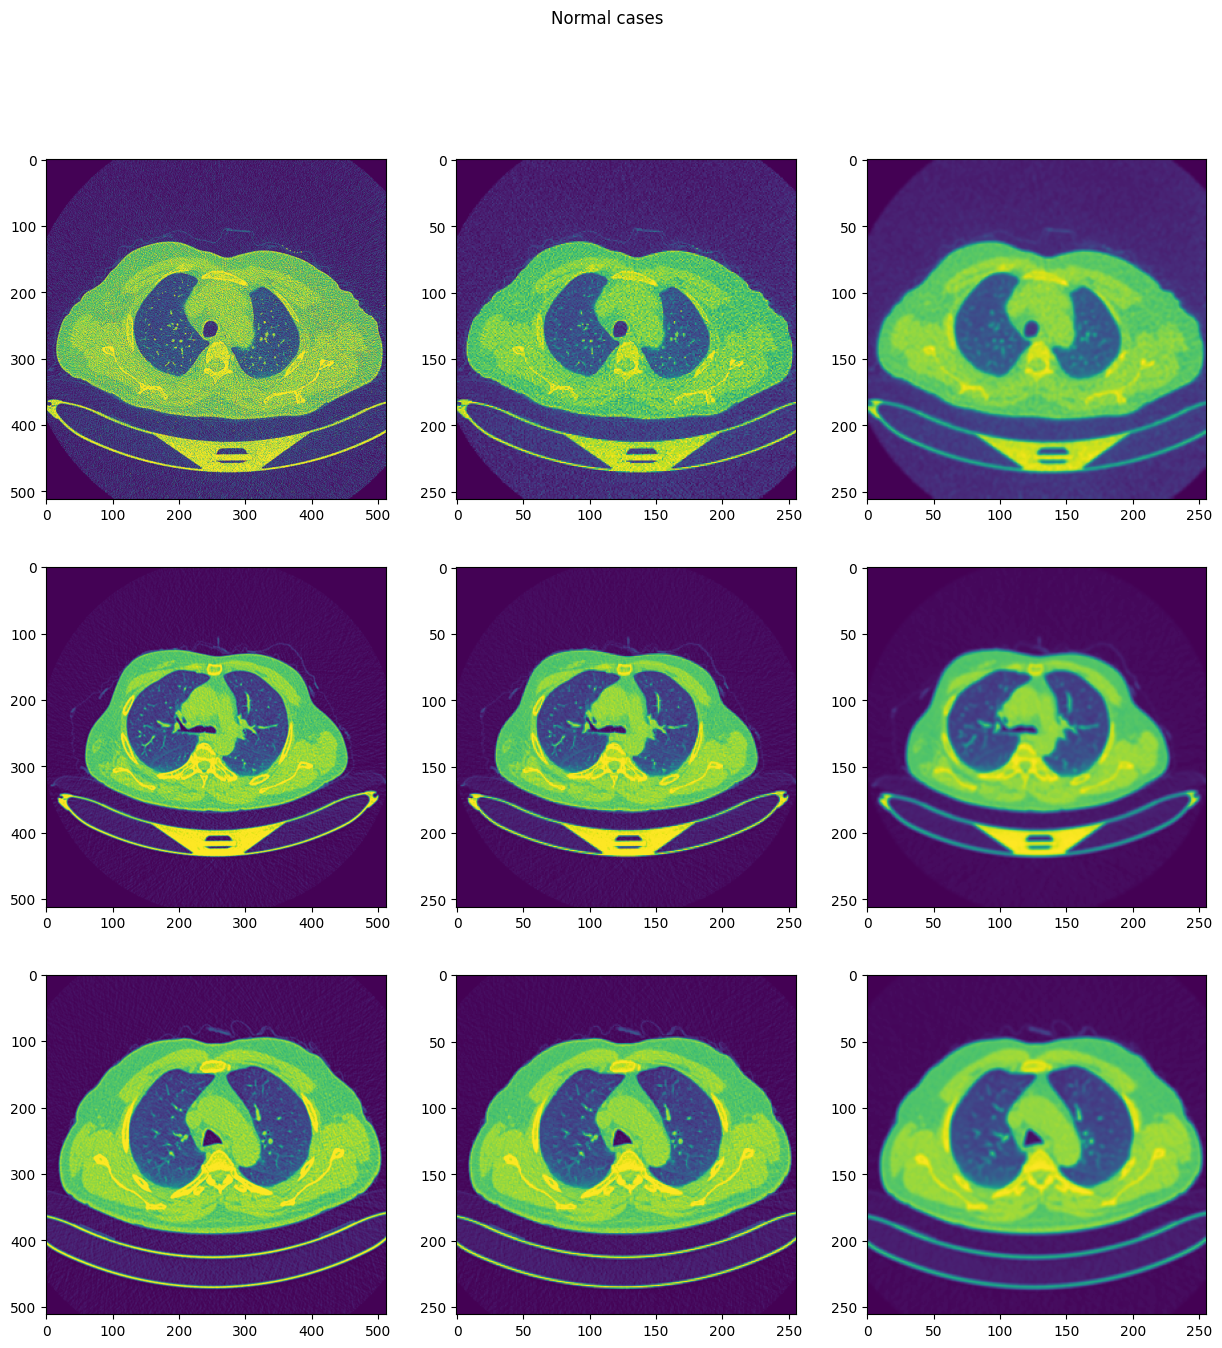

In [ ]:
img_size = 256

# Loop berjalan sekali untuk setiap kategori yang ada dalam daftar categories.
for i in categories:
  cnt, samples = 0, 3
  fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
  fig.suptitle(i)

  path = os.path.join(directory, i)
  class_num = categories.index(i)

  # Untuk setiap file (gambar) di dalam folder kategori yang sedang diproses oleh loop terluar.
  for curr_cnt, file in enumerate(os.listdir(path)):
    filepath = os.path.join(path, file)
    img = cv2.imread(filepath, 0)
    img0 = cv2.resize(img, (img_size, img_size))
    img1 = cv2.GaussianBlur(img0, (5, 5), 0)

    ax[cnt, 0].imshow(img)
    ax[cnt, 1].imshow(img0)
    ax[cnt, 2].imshow(img1)
    cnt += 1
    if cnt == samples:
        break

plt.show()

# Preparing Data

In [ ]:
data = []
img_size = 256

# Mengambil dan Memproses Gambar
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # Pra-Pemrosesan
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])

# Mengacak Data
random.shuffle(data)

# Memisahkan Fitur dan Label
X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

print('X length:', len(X))
print('y counts:', Counter(y))

# Normalisasi Data
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [ ]:
X.shape

(1097, 256, 256, 1)

In [ ]:
# Menampilkan
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print(len(X_train), X_train.shape)
print(len(X_test), X_test.shape)

877 (877, 256, 256, 1)
220 (220, 256, 256, 1)


# See the images

Train data Class :


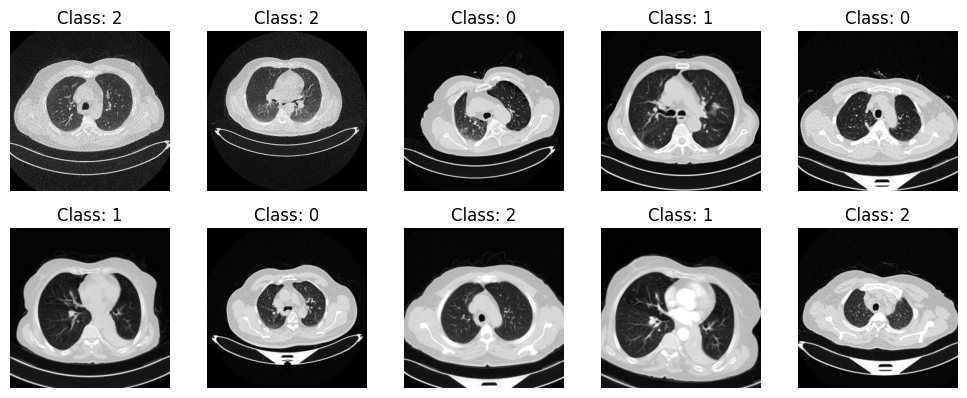

Test data Class :


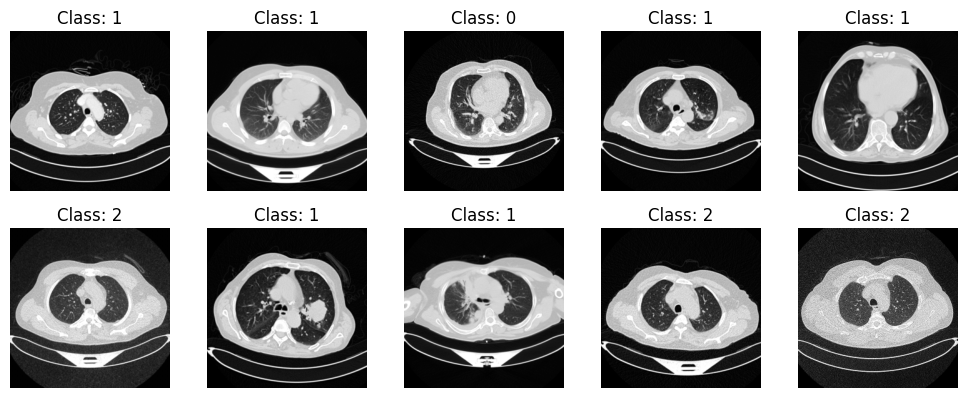

In [ ]:
import matplotlib.pyplot as plt

# Display images from X_train
plt.figure(figsize=(10, 10))
print("Train data Class :")
for i in range(10):  # Displaying 10 images
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')  # Assuming grayscale images
    plt.axis('off')
    plt.title(f"Class: {y_train[i]}")
plt.tight_layout()
plt.show()

print("==================================")

# Display images from X_valid
plt.figure(figsize=(10, 10))
print("Test data Class :")
for i in range(10):  # Displaying 10 images
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_test[i], cmap='gray')  # Assuming grayscale images
    plt.axis('off')
    plt.title(f"Class: {y_test[i]}")
plt.tight_layout()
plt.show()

# Applying SMOTE to oversample the data

In [ ]:
print(Counter(y_train), "\n", Counter(y_test))

Counter({np.int64(1): 451, np.int64(2): 329, np.int64(0): 97}) 
 Counter({np.int64(1): 110, np.int64(2): 87, np.int64(0): 23})


In [ ]:
print(len(X_train), X_train.shape)
X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)
print(len(X_train), X_train.shape)

877 (877, 256, 256, 1)
877 (877, 65536)


In [ ]:
# Smote Tuning Hyperparameter
print('Before SMOTE:', Counter(y_train))
smote = SMOTE(
  sampling_strategy={0: 451, 1: 451, 2:451},
  k_neighbors=5,
  random_state=42,
)
# Reshape X_train to 2D before applying SMOTE
X_train_temp = X_train.reshape(X_train.shape[0], img_size * img_size * 1)
X_train_sampled, y_train_sampled = smote.fit_resample(X_train_temp, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({np.int64(1): 451, np.int64(2): 329, np.int64(0): 97})
After SMOTE: Counter({np.int64(2): 451, np.int64(0): 451, np.int64(1): 451})


In [ ]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

877 (877, 256, 256, 1)
1353 (1353, 256, 256, 1)


# Model Building with SMOTE data

In [ ]:
model1 = Sequential()

model1.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(16))
model1.add(Dense(3, activation='softmax'))

model1.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 254, 254, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │     3,936,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,973,891 (15.16 MB)

 Trainable params: 3,973,891 (15.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model1.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 153s 5s/step - accuracy: 0.6442 - loss: 0.8039 - val_accuracy: 0.9364 - val_loss: 0.1850
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.9757 - loss: 0.1043 - val_accuracy: 0.9955 - val_loss: 0.0374
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - accuracy: 0.9944 - loss: 0.0188 - val_accuracy: 0.9682 - val_loss: 0.0594
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.9942 - loss: 0.0162 - val_accuracy: 0.9682 - val_loss: 0.0578
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 147s 5s/step - accuracy: 0.9903 - loss: 0.0311 - val_accuracy: 0.9909 - val_loss: 0.0247
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.9973 - loss: 0.0157 - val_accuracy: 1.0000 - val_loss: 0.0138
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - accuracy: 0.9998 - loss: 0.0046 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 198s 5s/step - accuracy: 0.9970 - loss: 0.0193 - val_accuracy: 0.9955 - v

# Results

In [ ]:
# Prediksi
y_pred_prob = model1.predict(X_test, verbose=1)
y_pred_test = np.argmax(y_pred_prob, axis=1)

# Evaluasi
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report CNN:")
print(classification_report(y_test, y_pred_test))

print("\nConfusion Matrix CNN:")
print(confusion_matrix(y_true=y_test, y_pred=y_pred_test))

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Classification Report CNN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00       110
           2       1.00      1.00      1.00        87

    accuracy                           1.00       220
   macro avg       1.00      1.00      1.00       220
weighted avg       1.00      1.00      1.00       220


Confusion Matrix CNN:
[[ 23   0   0]
 [  0 110   0]
 [  0   0  87]]


# Model Building with Class Weighted Approach

In [ ]:
model2 = Sequential()

model2.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(16))
model2.add(Dense(3, activation='softmax'))

model2.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 254, 254, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 125, 125, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │     3,936,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,973,891 (15.16 MB)

 Trainable params: 3,973,891 (15.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
new_weights = {
    0: X_train.shape[0]/(3*Counter(y_train)[0]),
    1: X_train.shape[0]/(3*Counter(y_train)[1]),
    2: X_train.shape[0]/(3*Counter(y_train)[2]),
}

# new_weights[0] = 0.5
# new_weights[1] = 20

new_weights

{0: 3.0444444444444443, 1: 0.6523809523809524, 2: 0.8782051282051282}

In [ ]:
history = model2.fit(X_train, y_train, batch_size=8, epochs=10, validation_data=(X_valid, y_valid), class_weight=new_weights)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.4451 - loss: 2.5750 - val_accuracy: 0.8364 - val_loss: 0.4196
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.9156 - loss: 0.2517 - val_accuracy: 0.9673 - val_loss: 0.1402
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9848 - loss: 0.1012 - val_accuracy: 0.9855 - val_loss: 0.0443
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9869 - loss: 0.0476 - val_accuracy: 0.9964 - val_loss: 0.0186
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.9956 - loss: 0.0435 - val_accuracy: 0.9891 - val_loss: 0.0479
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.9912 - loss: 0.0539 - val_accuracy: 0.9891 - val_loss: 0.0289
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.9997 - loss: 0.0079 - val_accuracy: 0.9855 - val_loss: 0.0351
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9888 - loss: 0.0260 - val_accu

# Results

In [ ]:
y_pred = model2.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

NameError: name 'model2' is not defined

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
val_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=8)
val_generator = val_datagen.flow(X_valid, y_valid, batch_size=8)

In [ ]:
model3 = Sequential()

model3.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(16))
model3.add(Dense(3, activation='softmax'))

model3.summary()

In [ ]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model3.fit_generator(train_generator, epochs=5, validation_data=val_generator, class_weight=new_weights)

In [ ]:
y_pred = model3.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

In [ ]:
# Buatkan Algoritma Naive Bias Classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

# Reshape ke 2D (sama seperti KNN)
X_train_nb = X_train_sampled.reshape(X_train_sampled.shape[0], -1)
X_test_nb = X_test.reshape(X_test.shape[0], -1)

# Inisialisasi dan training model Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_nb, y_train_sampled)

# Prediksi pada data validasi
y_pred_nb = nb_model.predict(X_test_nb)

# Evaluasi model
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))
print("\nNaive Bayes Confusion Matrix:")
print(confusion_matrix(y_true=y_test, y_pred=y_pred_nb))

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.96      0.59        23
           1       0.96      0.65      0.77       110
           2       0.68      0.74      0.71        87

    accuracy                           0.71       220
   macro avg       0.69      0.78      0.69       220
weighted avg       0.79      0.71      0.73       220


Naive Bayes Confusion Matrix:
[[22  1  0]
 [ 9 71 30]
 [21  2 64]]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Reshape ke 2D (WAJIB untuk KNN)
X_train_knn = X_train.reshape(X_train.shape[0], -1)
X_test_knn  = X_test.reshape(X_test.shape[0], -1)

# Pipeline: Scaling + KNN (KNN sensitif skala!)
knn_model = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(
        n_neighbors=4,        # 🔥 ganjil → hindari tie
        weights='distance',   # 🔥 kontribusi tetangga dekat lebih besar
        metric='minkowski',   # default (euclidean)
        n_jobs=-1
    ))
])

# Training model
knn_model.fit(X_train_knn, y_train_knn)

# Prediksi data uji
y_pred_knn = knn_model.predict(X_test_knn)

# Evaluasi model
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

print("\nKNN Confusion Matrix:")
print(confusion_matrix(y_true=y_test, y_pred=y_pred_knn))

NameError: name 'y_train_knn' is not defined

In [ ]:
# Buatkan Algoritma Support Vector Machine (SVM)
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Reshape ke 2D (sama seperti NB & KNN)
X_train_svm = X_train_sampled.reshape(X_train_sampled.shape[0], -1)
X_valid_svm = X_valid.reshape(X_valid.shape[0], -1)

# Pipeline: Scaling + SVM (WAJIB scaling!)
svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel='rbf',        # kernel non-linear (default & kuat)
        C=1.0,               # regularisasi
        gamma='scale',       # aman untuk data fitur besar
        class_weight='balanced',  # 🔥 penting untuk imbalance
        random_state=42
    ))
])

# Training model
svm_model.fit(X_train_svm, y_train_sampled)

# Prediksi pada data validasi
y_pred_svm = svm_model.predict(X_valid_svm)

# Evaluasi model
print("SVM Classification Report:")
print(classification_report(y_valid, y_pred_svm))
print("\nSVM Confusion Matrix:")
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_svm))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       0.99      1.00      0.99       141
           2       1.00      0.97      0.99       104

    accuracy                           0.99       275
   macro avg       0.98      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275


SVM Confusion Matrix:
[[ 30   0   0]
 [  0 141   0]
 [  1   2 101]]


In [ ]:
# Buatkan menggunakan random forest classifier
X_train_rf = X_train_sampled.reshape(X_train_sampled.shape[0], -1)
X_valid_rf = X_valid.reshape(X_valid.shape[0], -1)

# Pipeline: (Scaling optional) + Random Forest
rf_model = Pipeline([
    # ('scaler', StandardScaler()),  # ❌ tidak wajib untuk RF
    ('rf', RandomForestClassifier(
        n_estimators=300,        # 🔥 jumlah pohon
        max_depth=None,          # biarkan tumbuh optimal
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight='balanced', # 🔥 penting untuk imbalance
        random_state=42,
        n_jobs=-1
    ))
])

# Training model
rf_model.fit(X_train_rf, y_train_sampled)

# Prediksi data validasi
y_pred_rf = rf_model.predict(X_valid_rf)

# Evaluasi model
print("Random Forest Classification Report:")
print(classification_report(y_valid, y_pred_rf))
print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_rf))

NameError: name 'X_train_sampled' is not defined